In [1]:
using NCDatasets
using FileIO
using Statistics
using DelimitedFiles
using Plots
using Printf

In [2]:
#save_σ_hr()

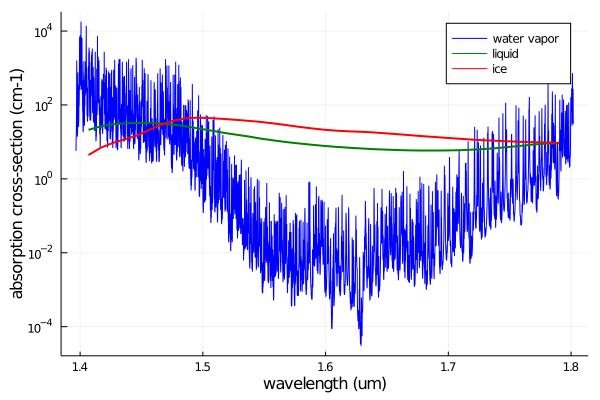

In [3]:
include("helper.jl")

hyp_wl, rad = read_Hyperion();
ν, k1 = make_vapor_xsection();
k2, k3 = read_Kuo_abs(hyp_wl);

plot_cross_sections(ν, k1, hyp_wl, k2, k3)

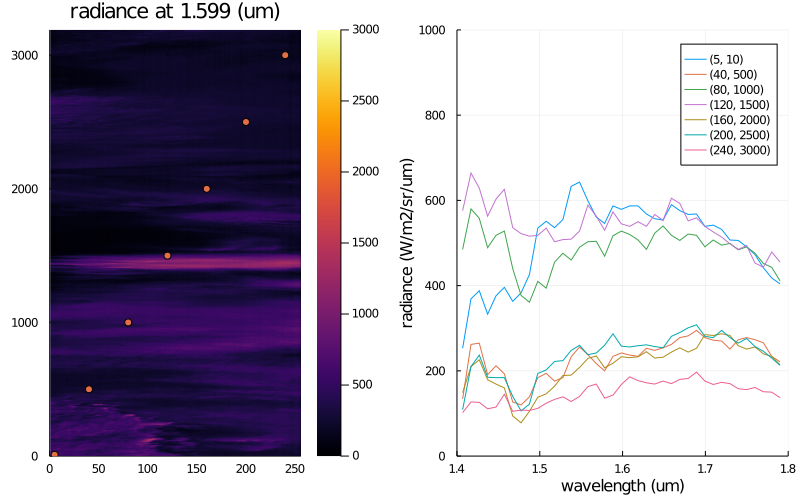

In [4]:
pts = [(5,10),(40,500),(80,1000),(120,1500),(160,2000),(200,2500),(240,3000)]

s = 20
rad_s = rad[:,s,:]'
p1 = heatmap(rad_s, clims=(0,3000), size=(400,500), title=@sprintf("radiance at %.3f (um)", hyp_wl[s]))
scatter!(pts, label="")
xlims!(0,256)
ylims!(0,3189)

p2 = plot()
for (i,j) in pts
    plot!(hyp_wl,rad[i,:,j], label="("*string(i)*", "*string(j)*")")
end

xlims!(1.4,1.8)
ylims!(0,1000)
xlabel!("wavelength (um)")
ylabel!("radiance (W/m2/sr/um)")
p = plot(p1,p2,layout=(1,2),size=(800,500))
savefig(p, "snapshot_data.png")
display(p)

In [13]:
sun = readdlm("solar_irrad_kurucz.txt");


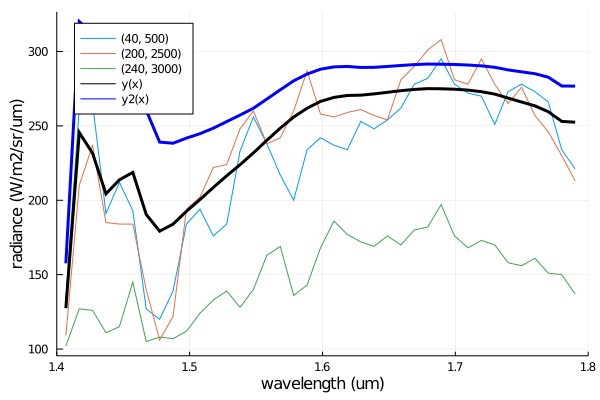

In [5]:
include("helper.jl")

hyp_wl, rad = read_Hyperion();
ν_hr, k1_hr = make_vapor_xsection();
hyp = KernelInstrument(gaussian_kernel(10, 0.005), 1e4 ./ hyp_wl);
k1 = conv_spectra(hyp, ν, k1_hr);
k2, k3 = read_Kuo_abs(hyp_wl);

function fwd_model(x; λ=hyp_wl, k1=k1, k2=k2, k3=k3)
    l, m, u1, u2, u3 = x;
    ρ = (l .+ λ*m) .* exp.( -1 .* (k1*u1 .+ k2*u2 .+ k3*u3));
    F = 400 * ones(length(λ));
    cosθ = 0.4;
    L = ρ .* F * cosθ / π;
    return L
end

function fwd_model_novapor(x; λ=hyp_wl,k2=k2, k3=k3)
    l, m, u2, u3 = x;
    ρ = (l .+ λ*m) .* exp.( -1 .* (k2*u2 .+ k3*u3));
    return L
end

#pts = [(5,10),(40,500),(80,1000),(120,1500),(160,2000),(200,2500),(240,3000)]
pts = [(40,500),(200,2500),(240,3000)]

p = plot()
for (i,j) in pts
    plot!(hyp_wl, rad[i,:,j], label="("*string(i)*", "*string(j)*")")
end

y = fwd_model([15, -5, 1e16, 1e-2, 1e-2])
plot!(hyp_wl, y, color=:black, lw=3, label="y(x)", legend=:topleft)

y = fwd_model([15, -5, 1e16, 0.0, 1e-2])
plot!(hyp_wl, y, color=:blue, lw=3, label="y2(x)", legend=:topleft)

xlims!(1.4,1.8)
xlabel!("wavelength (um)")
ylabel!("radiance (W/m2/sr/um)")
display(p)